##  Optimze and a Dense Neural Network for gap filling and feature identification

** With a few tweaks to RepRunner, an LSTM can be run instead

In [1]:
import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations
# from functools import partial
from multiprocessing import Pool
from functools import partial
from sklearn import metrics
# from sklearn.model_selection import train_test_split

## Personal Modules
import ReadStandardTimeFill as RSTF
import importlib
import DenseNet as Dense
import MiscFuncs as MF
importlib.reload(Dense)
importlib.reload(RSTF)
importlib.reload(MF)

# %matplotlib inline

%matplotlib notebook
%config IPCompleter.greedy=True

from scipy.optimize import minimize, curve_fit
from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel
from sklearn.externals import joblib
from matplotlib import cm

from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

from ipywidgets import FloatProgress
from IPython.display import display
import os  
import shutil
from keras import backend as K
try:pool.close()
except:pass


def Test(params,X,y,YScaled,XScaled,pool):
    return(np.random.rand(params['K']))


def ModSelect(Scope,Site):
    if Site == 'Illisarvik':
        if Scope == 'Full':
            Model = ['wind_speed','air_pressure','PPFD_Avg','AirTC_Avg','VPD',
                    'Temp','VWC','Sedge','Shrub','Grass','Sparse','Out_of_Basin']
        if Scope == 'Test':
            Model = ['PPFD_Avg','Sedge']
    if Site == 'FishIsland':
        BaseFactors = []
        if Scope == 'Full':
            Model = ['H','Wind Spd','air pressure','Ta','Rn','PPFD','Rain','Water Table',
            'Ts 2.5 cm','Ts 15 cm','VWC','Active Layer','24H Rain','Wtr Tbl Trnd']
        if Scope == 'Test':
            Model = ['H','Water Table','Wind Spd','Active Layer']
    return(Model)

def Combos(Model,L,factor=None):
    Models=[]
    for c in combinations(Model,L):
        c = list(c)
        if factor is None:
            Models.append(c)
        else:
            for f in factor:
                f = f.split('+')
                if set(f).issubset(set(c)) and c not in Models:
                    Models.append(c)
                    
    print('Models: ',Models)
    return(Models)

def Stats(mse,j,i,params):
    df = pd.DataFrame(index = [str(j)+'_'+str(i)],
                      data={'Model':[params['Model']],
                            'MSE':[mse.mean()],
                            'Size':j,
                            'Number':i,
                            'SE':[mse.std()/params['K']**.5],
                            'Performance':0})
    return(df)

def t(p,n):
    alpha = 1-p
    df = n-1
    return(stats.t.ppf(alpha,df))


FirstRun = True
# FirstRun = False

MP=True
processes=3
Scope = 'Full'
cwd = os.getcwd()
# for Site in ['Illisarvik','FishIsland']:
Site='Illisarvik'
target='fch4'
T= 1#t(0.05,params['K'])


Using TensorFlow backend.


# Model

A Jupyter Widget

Models:  [['wind_speed'], ['air_pressure'], ['PPFD_Avg'], ['AirTC_Avg'], ['VPD'], ['Temp'], ['VWC'], ['Sedge'], ['Shrub'], ['Grass'], ['Sparse'], ['Out_of_Basin']]
['Sedge']
Models:  [['wind_speed', 'Sedge'], ['air_pressure', 'Sedge'], ['PPFD_Avg', 'Sedge'], ['AirTC_Avg', 'Sedge'], ['VPD', 'Sedge'], ['Temp', 'Sedge'], ['VWC', 'Sedge'], ['Sedge', 'Shrub'], ['Sedge', 'Grass'], ['Sedge', 'Sparse'], ['Sedge', 'Out_of_Basin']]
['VWC+Sedge']
Models:  [['wind_speed', 'VWC', 'Sedge'], ['air_pressure', 'VWC', 'Sedge'], ['PPFD_Avg', 'VWC', 'Sedge'], ['AirTC_Avg', 'VWC', 'Sedge'], ['VPD', 'VWC', 'Sedge'], ['Temp', 'VWC', 'Sedge'], ['VWC', 'Sedge', 'Shrub'], ['VWC', 'Sedge', 'Grass'], ['VWC', 'Sedge', 'Sparse'], ['VWC', 'Sedge', 'Out_of_Basin']]
['Temp+VWC+Sedge']
Models:  [['wind_speed', 'Temp', 'VWC', 'Sedge'], ['air_pressure', 'Temp', 'VWC', 'Sedge'], ['PPFD_Avg', 'Temp', 'VWC', 'Sedge'], ['AirTC_Avg', 'Temp', 'VWC', 'Sedge'], ['VPD', 'Temp', 'VWC', 'Sedge'], ['Temp', 'VWC', 'Sedge', 'Shrub'], 

[ 'wind_speed+air_pressure+PPFD_Avg+AirTC_Avg+VPD+Temp+VWC+Sedge+Shrub+Grass'
 'wind_speed+air_pressure+PPFD_Avg+AirTC_Avg+VPD+Temp+VWC+Sedge+Shrub+Sparse'
 'wind_speed+air_pressure+PPFD_Avg+AirTC_Avg+VPD+Temp+VWC+Sedge+Shrub+Out_of_Basin'
 'wind_speed+air_pressure+PPFD_Avg+AirTC_Avg+Temp+VWC+Sedge+Shrub+Sparse+Out_of_Basin'
 'wind_speed+air_pressure+PPFD_Avg+VPD+Temp+VWC+Sedge+Shrub+Sparse+Out_of_Basin'
 'wind_speed+air_pressure+AirTC_Avg+VPD+Temp+VWC+Sedge+Shrub+Sparse+Out_of_Basin']
Models:  [['wind_speed', 'air_pressure', 'PPFD_Avg', 'AirTC_Avg', 'VPD', 'Temp', 'VWC', 'Sedge', 'Shrub', 'Grass', 'Sparse'], ['wind_speed', 'air_pressure', 'PPFD_Avg', 'AirTC_Avg', 'VPD', 'Temp', 'VWC', 'Sedge', 'Shrub', 'Grass', 'Out_of_Basin'], ['wind_speed', 'air_pressure', 'PPFD_Avg', 'AirTC_Avg', 'VPD', 'Temp', 'VWC', 'Sedge', 'Shrub', 'Sparse', 'Out_of_Basin'], ['wind_speed', 'air_pressure', 'PPFD_Avg', 'AirTC_Avg', 'Temp', 'VWC', 'Sedge', 'Shrub', 'Grass', 'Sparse', 'Out_of_Basin'], ['wind_speed'

<IPython.core.display.Javascript object>


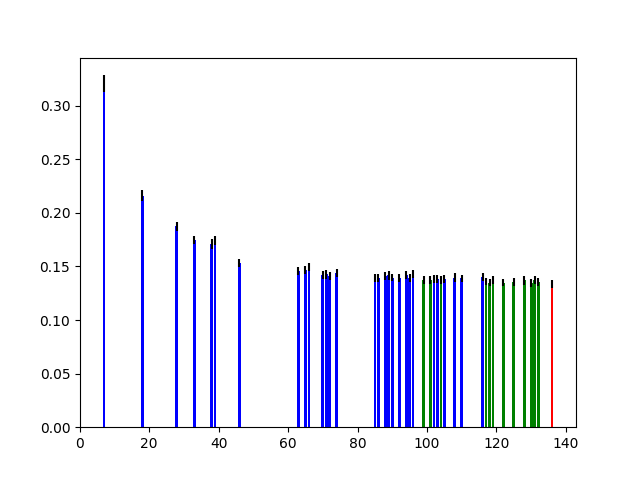

In [2]:

if __name__ == '__main__' and FirstRun == True:
    XVarriables=ModSelect(Scope,Site)
    prog = FloatProgress(min=0, max=len(XVarriables)+1,description='Running:') # instantiate the bar
    display(prog) # display the bar
    try:shutil.rmtree(cwd+'/'+Site+'/'+target+'/')
    except:pass
    os.mkdir(cwd+'/'+Site+'/'+target+'/')
    for j in range(1,len(XVarriables)+1):
        if j == 1: Inputs = (Combos(XVarriables,j))
        else: Inputs = (Combos(XVarriables,j,Factors))
        i = 0
        for Input in Inputs:
            params = Dense.Params(Scope,target,MP)
            params['Dpath'] = cwd+'/'+Site+'/'
            params['Spath'] = params['Dpath']+'/'+target+'/'+str(j)+'_'+str(i)+'/'
            try:os.mkdir(params['Spath'])
            except:pass
            params['Sname'] = 'Y_'
            params['Inputs'] = Input
            params['Model'] = '+'.join(params['Inputs'])
            RST = RSTF.ReadStandardTimeFill(params,'ECData.csv')#,resample='2H')
            RST.Scale(params['target'],params['Inputs']) 
            y = RST.y*1.0
            X = RST.X*1.0
            params['N']=int(y.shape[0]/30)
            params['Memory'] = (math.floor(100/params['proc'])- 5/params['proc']) * .01
            Y_hat=[]
            y_true=[]
            X_true=[]
            index=[]
            ones=[]
            if MP == False:
                for k in range(params['K']):
                    results = Dense.TTV_Split(k,params,X,y)
                    Y_hat.append(RST.YScaled.inverse_transform(results[0]))
                    y_true.append(RST.YScaled.inverse_transform(results[1]))
                    X_true.append(RST.XScaled.inverse_transform(results[2]))
                    index.append(results[3])
                    ones.append(results[4])
            else:
                pool = Pool(processes=processes,maxtasksperchild=75)
                for k,results in enumerate(pool.imap(partial(Dense.TTV_Split,params=params,X=X,y=y),range(params['K']))):
                    Y_hat.append(RST.YScaled.inverse_transform(results[0]))
                    y_true.append(RST.YScaled.inverse_transform(results[1]))
                    X_true.append(RST.XScaled.inverse_transform(results[2]))
                    index.append(results[3])
                    ones.append(results[4])
                pool.close()
            Y_hat = np.squeeze(np.asanyarray(Y_hat))
            y_true = np.squeeze(np.asanyarray(y_true))
            X_true = np.asanyarray(X_true)
            index = np.asanyarray(index)
            ones = np.asanyarray(ones)
            params['Memory'] = .95
            if MP == False:
                for k in range(1):
                     mse = Dense.Sort_outputs(k,params,Y_hat,y_true,X_true,index,ones)
            else:
                pool = Pool(processes=1,maxtasksperchild=75)
                for k,results in enumerate(pool.imap(partial(Dense.Sort_outputs,params=params,
                 Y_hat=Y_hat,y_true=y_true,X_true=X_true,index=index,ones=ones),range(1))):
                     mse = results
                pool.close()
            if i == 0:Level = Stats(mse,j,i,params)
            else:Level = Level.append(Stats(mse,j,i,params))
            i += 1
            prog.value=j+i/len(Inputs)
        Min = Level.loc[Level['MSE']==Level['MSE'].min()]
        T= 1#t(0.05,params['K'])
        Factors = Level.loc[Level['MSE']<=Min['MSE'].values[0]+Min['SE'].values[0]*T,'Model'].values
        print(Factors)
        Level.loc[Level['MSE']<=Min['MSE'].values[0]+Min['SE'].values[0]*T,'Performance']=1
        if j == 1:Records = Level
        else:Records = Records.append(Level)

    Records = Records.reset_index(drop=True)
    Min = Records.loc[Records['MSE']==Records['MSE'].min()]
    Records.loc[Records['MSE']<=Min['MSE'].values[0]+Min['SE'].values[0]*T,'Performance']=2
    Records.loc[Records['MSE']==Min['MSE'].values[0],'Performance']=3
    Honorable = Records.loc[Records['Performance']==1]
    Top = Records.loc[Records['Performance']==2]
    Best = Records.loc[Records['Performance']==3]
    plt.figure()
    plt.bar(Honorable.index,Honorable['MSE'],yerr=Honorable['SE'],color='blue')
    plt.bar(Top.index,Top['MSE'],yerr=Top['SE'],color='green')
    plt.bar(Best.index,Best['MSE'],yerr=Best['SE'],color='red')
    Records.drop(Records.columns[Records.columns.str.contains('Unnamed',case = False)],axis = 1)
    Records.to_csv(params['Dpath']+'/'+target+'_Runs.csv')
    FirstRun = False
else:    
    print('OldRun!')
#     params['Spath'] = params['Dpath']+'/'+target+'/'+str(j)+'_'+str(i)+'/'
    params = Dense.Params(Scope,target,MP)
    params['Dpath'] = cwd+'/'+Site+'/'
    RST = RSTF.ReadStandardTimeFill(params,'ECData.csv')#,resample='2H')
    params = Dense.Params(Scope,target,MP)
    params['Dpath'] = cwd+'/'+Site+'/'
    Records = pd.read_csv(params['Dpath']+'/'+target+'_Runs.csv',delimiter = ',',header = 0)
    Min = Records.loc[Records['MSE']==Records['MSE'].min()]
    Records.loc[Records['MSE']<=Min['MSE'].values[0]+Min['SE'].values[0]*T,'Performance']=2
    Records.loc[Records['MSE']==Min['MSE'].values[0],'Performance']=3
    T= 1#t(0.05,params['K'])
    Honorable = Records.loc[Records['Performance']==1]
    Top = Records.loc[Records['Performance']==2]
    Best = Records.loc[Records['Performance']==3]
    plt.figure()
    plt.bar(Honorable.index,Honorable['MSE'],yerr=Honorable['SE'],color='blue')
    plt.bar(Top.index,Top['MSE'],yerr=Top['SE'],color='green')
    plt.bar(Best.index,Best['MSE'],yerr=Best['SE'],color='red')
    Records.to_csv(params['Dpath']+'/'+target+'_Runs.csv')
    print(Records)

# Map Results

# Predict

In [ ]:

plt.figure(figsize=(8,7))
Data = Data.sort_values(by=Key)
# Data.index = Data[Key]

Data = Data[np.isfinite(Data['True'])]

plt.scatter(RST.Master[Key],RST.Master[target],edgecolor='black',facecolor='white')
plt.plot(Data[Key],Data[target],
         label= params['target']+' Model\nr^2: '+str(np.round(metrics.r2_score(Data['True'],
                                                                   Data[params['target']])**2,3)))
# plt.plot(Data.index,Data['Var'],label= params['target']+
# ' Model\nRMSE: '+str(np.round(metrics.mean_squared_error(Data['True'],
#                                                                    Data[params['target']])**2,3)))


plt.fill_between(Data[Key], Data[target]-Data['PI'], 
                 Data[target]+Data['PI'],  color = 'green', alpha = 0.4, 
                 label = '95% PI')
plt.fill_between(Data[Key], Data[target]-Data['CI'], 
                 Data[target]+Data['CI'],  color = 'red', alpha = 0.4, 
                 label = '95% CI')
plt.legend()
# print(RST.Master)

plt.figure()

# plt.plot(Data[Key], Data['Var'])

plt.scatter(Data[target],Data['True'])

# print(Data['SE'])

NameError: name 'np' is not defined